In [1]:
# ===============================================
# 0. 기본 설정 및 한글 폰트 설정
# ===============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


In [2]:
# ===============================================
# 1. 데이터 로딩 및 병합
# ===============================================

# 1) CSV 파일 로딩
df_kbo = pd.read_csv("kbo_dataset_2018_2024.csv")
df_kbo = df_kbo[df_kbo["year"] == 2023].copy()

df_mlb = pd.read_csv("batting_2023_data.csv")

# 2) 컬럼명 전부 소문자로 변환 (대소문자 오류 방지)
df_kbo.columns = df_kbo.columns.str.lower()
df_mlb.columns = df_mlb.columns.str.lower()

# 3) MLB 컬럼명을 KBO 컬럼에 맞춰 rename
df_mlb.rename(columns={
    "name": "player_name",
    "avg": "batting_avg",
    "obp": "onbase_perc",
    "slg": "slugging_perc",
    "ops": "onbase_plus_slugging"
}, inplace=True)

# 4) 공통 컬럼 정의 (모두 소문자)
common_cols = [
    'player_name', 'team', 'g', 'ab', 'pa', 'h', '2b', '3b', 'hr', 'r', 'rbi',
    'bb', 'ibb', 'so', 'hbp', 'sf', 'sh', 'sb', 'cs',
    'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging'
]

# 5) 공통 컬럼만 선택
df_kbo = df_kbo[common_cols].copy()
df_mlb = df_mlb[common_cols].copy()

# 6) 리그 구분 열 추가
df_kbo["리그"] = "KBO"
df_mlb["리그"] = "MLB"

# 7) 최종 병합
df_combined = pd.concat([df_kbo, df_mlb], ignore_index=True)



In [3]:
# ===============================================
# 2. 비율 기준 정규화: 리그 간 경기 수 차이 보정
# ===============================================
# 전제: df_combined은 KBO/MLB가 병합된 상태이며, 컬럼은 모두 소문자임

# 예외 방지: PA가 0인 경우는 결측 처리 또는 0으로 나눗셈 방지
df_combined = df_combined[df_combined["pa"] > 0].copy()

# 홈런, 볼넷, 타점의 타석(PA) 대비 비율 계산
df_combined["hr_per_pa"] = df_combined["hr"] / df_combined["pa"]
df_combined["bb_per_pa"] = df_combined["bb"] / df_combined["pa"]
df_combined["rbi_per_pa"] = df_combined["rbi"] / df_combined["pa"]

# 결과 확인용 상위 5개 출력
df_combined[["player_name", "team", "리그", "hr_per_pa", "bb_per_pa", "rbi_per_pa"]].head()



,player_name,team,리그,hr_per_pa,bb_per_pa,rbi_per_pa
0,Sócrates Brito,Kia Tigers,KBO,0.032895,0.085526,0.157895
1,Woo-hyuk Byun,Kia Tigers,KBO,0.030973,0.101770,0.106195
2,Hyoung Woo Choi,Kia Tigers,KBO,0.033465,0.127953,0.159449
3,Jeong Yong Choi,Kia Tigers,KBO,0.000000,0.048780,0.024390
4,Won Jun Choi,Kia Tigers,KBO,0.003650,0.113139,0.083942


In [4]:
# 정규성 및 등분산성 검정
#from scipy.stats import shapiro, levene

#print("Shapiro-Wilk 정규성 검정 (hr_per_pa)")
#for league in ["mlb", "kbo"]:
 #   p = shapiro(df_combined[df_combined["리그"] == league]["hr_per_pa"])[1]
  #  print(f"{league.upper()}: p = {p:.4f}")

#print("\nLevene 등분산 검정")
#p = levene(
 #   df_combined[df_combined["리그"] == "mlb"]["hr_per_pa"],
  #  df_combined[df_combined["리그"] == "kbo"]["hr_per_pa"]
#)[1]
#print(f"Levene p = {p:.4f}")


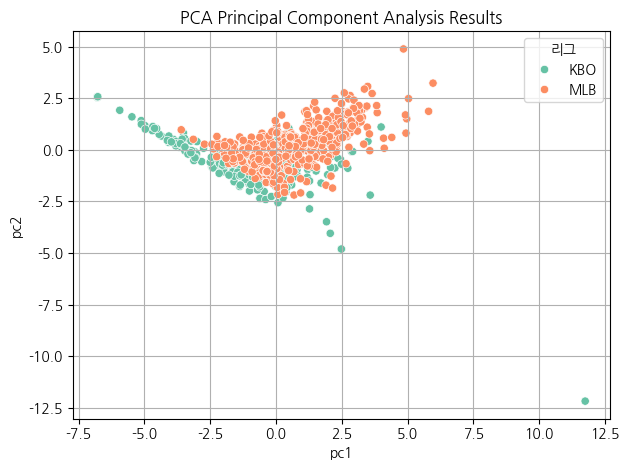

In [5]:
# ===============================================
# 3. PCA 분석 (ops 기반 분포 시각화 - 소문자 기준)
# ===============================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 사용될 주요 지표 (소문자 기준)
features = ['hr', 'bb', 'so', 'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging']

# 결측치 제거
df_pca = df_combined.dropna(subset=features).copy()

# 입력 데이터와 라벨
X = df_pca[features]
y = df_pca["리그"]

# 스케일링
X_scaled = StandardScaler().fit_transform(X)

# PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과를 DataFrame으로 정리
pca_df = pd.DataFrame(X_pca, columns=["pc1", "pc2"])
pca_df["리그"] = y.values

# 시각화
sns.scatterplot(data=pca_df, x="pc1", y="pc2", hue="리그", palette="Set2")
plt.title("PCA Principal Component Analysis Results")  #PCA 주성분 분석 결과
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# ===============================================
# 4. 통합 점수 계산 (df_pca 기준, 소문자 컬럼명)
# ===============================================

from sklearn.preprocessing import StandardScaler

# 1) 통합 점수 계산 대상 feature 정의
features = ['hr', 'bb', 'so', 'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging']

# 2) 결측치 제거된 데이터프레임(df_pca) 기준 정규화
df_pca = df_combined.dropna(subset=features).copy()

# 3) 스케일링
X = df_pca[features]
X_scaled = StandardScaler().fit_transform(X)

# 4) 가중치 정의 (전부 소문자 key)
weights = {
    'onbase_plus_slugging': 0.4,
    'slugging_perc': 0.2,
    'onbase_perc': 0.2,
    'batting_avg': 0.1,
    'hr': 0.05,
    'bb': 0.05
}

# 5) 통합 점수 계산
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled["통합점수"] = sum(df_scaled[col] * w for col, w in weights.items())

# 6) df_pca에 통합 점수 연결 (행 수 동일하므로 오류 없음)
df_pca["통합점수"] = df_scaled["통합점수"].values

#  결과 확인 (선택)
df_pca[["player_name", "리그", "통합점수"]].head()



,player_name,리그,통합점수
0,Sócrates Brito,KBO,0.795158
1,Woo-hyuk Byun,KBO,-0.004126
2,Hyoung Woo Choi,KBO,1.196733
3,Jeong Yong Choi,KBO,-1.270059
4,Won Jun Choi,KBO,0.078632


In [7]:

# ===============================================
# 5. 클러스터링 + 성향 부여
# ===============================================
from sklearn.cluster import KMeans

df_cluster = df_combined.dropna(subset=features).copy()
X_cluster = StandardScaler().fit_transform(df_cluster[features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster["클러스터"] = kmeans.fit_predict(X_cluster)

label_map = {
    0: "power hitter", # 장타형
    1: "On-base type", # 출루형
    2: "Contact type", #컨텍형
    3: "Base running type"  #주루형
}
df_cluster["성향"] = df_cluster["클러스터"].map(label_map)


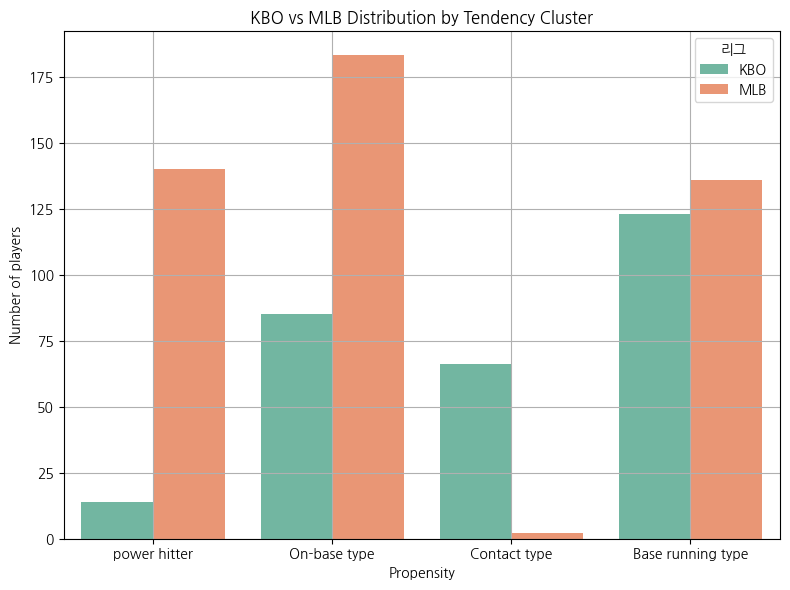

In [8]:

# ===============================================
# 6. 클러스터 분포 시각화
# ===============================================
plt.figure(figsize=(8, 6))
sns.countplot(data=df_cluster, x="성향", hue="리그", palette="Set2")
plt.title("KBO vs MLB Distribution by Tendency Cluster") #성향 클러스터별 KBO vs MLB 분포"
plt.xlabel("Propensity") #타자 성향
plt.ylabel("Number of players") # 선수 수
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# ===============================================
# 7. 통합점수 vs PCA 주성분 상관 검정 (소문자 컬럼 기준)
# ===============================================
from scipy.stats import pearsonr

# 1. PCA 결과 중 첫 번째 주성분 (PC1)
pc1 = pca_df["pc1"].values

# 2. 통합점수는 df_pca에 저장되어 있음
composite = df_pca["통합점수"].values

# 3. 피어슨 상관계수 계산
r, p = pearsonr(composite, pc1)
print(f"통합점수 vs PC1 상관계수 r = {r:.3f}, p = {p:.4f}")


통합점수 vs PC1 상관계수 r = 0.966, p = 0.0000


In [10]:

# ===============================================
# 8. 머신러닝 모델 비교 (리그 분류)
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X = X_scaled
y = y.map({"KBO": 0, "MLB": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} 정확도: {acc:.3f}")
    print(classification_report(y_test, y_pred))


RandomForest 정확도: 0.827
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        60
           1       0.82      0.91      0.86        90

    accuracy                           0.83       150
   macro avg       0.83      0.81      0.81       150
weighted avg       0.83      0.83      0.82       150


LogisticRegression 정확도: 0.800
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        60
           1       0.80      0.89      0.84        90

    accuracy                           0.80       150
   macro avg       0.80      0.78      0.78       150
weighted avg       0.80      0.80      0.80       150


SVM 정확도: 0.867
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        60
           1       0.84      0.96      0.90        90

    accuracy                           0.87       150
   macro avg       0.88      0.84      0.86       150
we

In [11]:
import pandas as pd

# CSV 파일 로딩 (파일 경로는 실행 환경에 맞게 설정 필요)
df_kbo = pd.read_csv("kbo_dataset_2018_2024.csv")
df_kbo = df_kbo[df_kbo["year"] == 2023].copy()

df_mlb = pd.read_csv("batting_2023_data.csv")

# 컬럼명 소문자 통일
df_kbo.columns = df_kbo.columns.str.lower()
df_mlb.columns = df_mlb.columns.str.lower()

# MLB 컬럼명을 KBO 컬럼에 맞게 정렬
df_mlb.rename(columns={
    "name": "player_name",
    "avg": "batting_avg",
    "obp": "onbase_perc",
    "slg": "slugging_perc",
    "ops": "onbase_plus_slugging"
}, inplace=True)

# 공통 컬럼 지정
common_cols = [
    'player_name', 'team', 'g', 'ab', 'pa', 'h', '2b', '3b', 'hr', 'r', 'rbi',
    'bb', 'ibb', 'so', 'hbp', 'sf', 'sh', 'sb', 'cs',
    'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging'
]

# 공통 컬럼 기준 정제
df_kbo = df_kbo[common_cols].copy()
df_mlb = df_mlb[common_cols].copy()

# 리그 구분 컬럼 추가
df_kbo["리그"] = "KBO"
df_mlb["리그"] = "MLB"

# 병합
df_combined = pd.concat([df_kbo, df_mlb], ignore_index=True)

# 확인
df_combined.head()

,player_name,team,g,ab,pa,h,2b,3b,hr,r,...,hbp,sf,sh,sb,cs,batting_avg,onbase_perc,slugging_perc,onbase_plus_slugging,리그
0,Sócrates Brito,Kia Tigers,142,547,608,156,31,3,20,91,...,1,8,0,15,6,0.285,0.344,0.463,0.806,KBO
1,Woo-hyuk Byun,Kia Tigers,83,200,226,45,4,0,7,23,...,3,0,0,0,0,0.225,0.314,0.350,0.664,KBO
2,Hyoung Woo Choi,Kia Tigers,121,431,508,130,27,1,17,64,...,8,4,0,0,0,0.302,0.400,0.487,0.887,KBO
3,Jeong Yong Choi,Kia Tigers,56,36,41,6,1,0,0,17,...,0,0,3,4,0,0.167,0.211,0.194,0.405,KBO
4,Won Jun Choi,Kia Tigers,67,239,274,61,11,2,1,37,...,0,0,4,13,5,0.255,0.341,0.331,0.671,KBO


클러스터별 리그 분포 (Top 5 변수 기반):


리그,KBO,MLB
cluster,,
0,0.088235,0.911765
1,0.482639,0.517361
2,0.945946,0.054054
3,0.266932,0.733068


<Figure size 800x500 with 0 Axes>

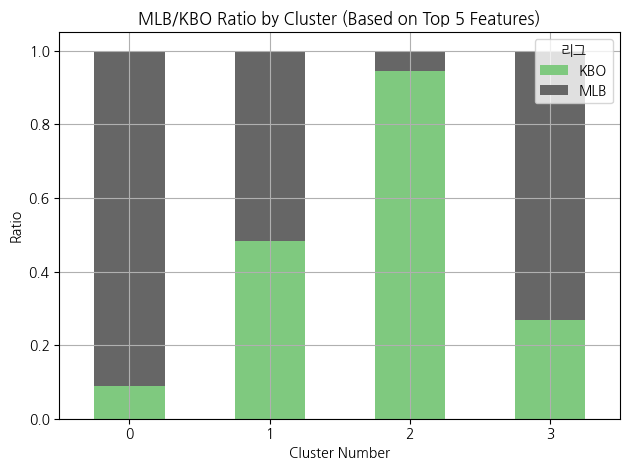

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 가정: df_combined는 MLB + KBO 데이터 병합 결과 (이미 존재)
# 분석에 사용할 주요 타자 지표
features = ['hr', 'bb', 'so', 'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging']

# 1. 결측치 제거
df_pca = df_combined.dropna(subset=features).copy()

# 2. 입력 변수(X), 타겟(y) 설정
X = df_pca[features]
y = df_pca['리그']

# 3. 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# 4. 랜덤 포레스트 분류기 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

# 5. 변수 중요도 기반 상위 5개 선택
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

top_n = 5
top_features = feature_importance['Feature'][:top_n].tolist()

# 6. 클러스터링용 데이터 구성 (상위 5개 변수만 사용)
X_cluster_input = X_scaled[top_features]

#  클러스터 수 = 4 설정: 타자 유형 (장타형, 출루형, 삼진형, 균형형)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_input)

# 7. 결과 통합
cluster_df = X_scaled.copy()
cluster_df['cluster'] = clusters
cluster_df['리그'] = y.values

# 8. 클러스터별 리그 비율 계산
cluster_league_dist = cluster_df.groupby('cluster')['리그'].value_counts(normalize=True).unstack().fillna(0)

# 클러스터 설명 지정
cluster_labels = {
    0: "Power Hitter (MLB 특화)",       # 장타형
    1: "On-base Type (KBO 중심)",        # 출루형
    2: "Contact Type (양 리그 혼합)",     # 컨택형
    3: "Base Running Type (KBO 강세)"    # 주루형
}


# 클러스터 번호 → 설명 텍스트 매핑
x_labels = [cluster_labels[i] for i in cluster_league_dist.index]

print("클러스터별 리그 분포 (Top 5 변수 기반):")
display(cluster_league_dist)

# 9. 시각화
plt.figure(figsize=(8, 5))
cluster_league_dist.plot(kind='bar', stacked=True, colormap='Accent')
plt.title("MLB/KBO Ratio by Cluster (Based on Top 5 Features)") #클러스터별 MLB/KBO 비율 (Top 5 Features 기반
plt.ylabel("Ratio")
plt.xlabel("Cluster Number")#클러스터 번호
plt.xticks(rotation=0)
plt.legend(title="리그")
plt.tight_layout()
plt.grid(True)
plt.show()
